In [1]:
# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# load message/ cover images
msg = cv2.imread("msg.png")    
msg = cv2.cvtColor(msg, cv2.COLOR_BGR2GRAY)

cover = cv2.imread("cover.png")  
cover = cv2.cvtColor(cover, cv2.COLOR_BGR2GRAY)

In [3]:
# function to show images 
def imshow(image, *args, **kwargs):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    plt.imshow(image, *args, **kwargs)
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.axis('off')
    plt.show()


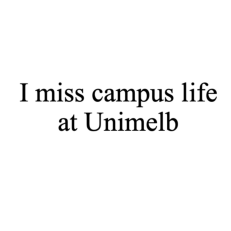

(580, 580) uint8


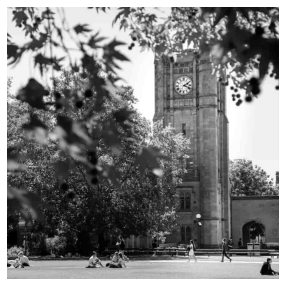

(580, 580) uint8


In [4]:
# check the size of images and visualise them
imshow(msg, cmap = 'gray')
print(msg.shape, msg.dtype)

imshow(cover, cmap = 'gray')
print(cover.shape, cover.dtype)


In [5]:
# Gaussian highpass filter
def Gauss_HighPass(f,radius_high):   
    
    m = f.shape[0]
    n = f.shape[1]
    mask = np.zeros((m, n))
    
    x0 = np.floor(m/2)
    y0 = np.floor(n/2)
    for i in range(m):
        for j in range(n):
            dis = np.sqrt((i - x0)**2 + (j - y0)**2)
            mask[i][j] = 1-np.exp((-1)*dis**2/2/(radius_high**2))    
    
    result = np.multiply(f, mask) 
    return result,mask

# Gaussian lowpass filter
def Gauss_LowPass(f,radius_low):        
    
    m = f.shape[0]
    n = f.shape[1]
    mask = np.zeros((m, n))
  
    x0 = np.floor(m/2)
    y0 = np.floor(n/2)
    for i in range(m):
        for j in range(n):
            dis = np.sqrt((i - x0)**2 + (j - y0)**2)
            mask[i][j] = np.exp((-1)*dis**2/2/(radius_low**2))
        
    result = np.multiply(f, mask) 
    return result,mask

In [6]:
# For quantitative analysis
# the code is from https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

# the 'Mean Squared Error'; the lower the error, the more "similar"
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# compute the mean squared error and structural similarity
def compare_images(imageA, imageB):
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    print("MSE: %.2f, SSIM: %.2f" % (m, s))
    

#### High Pass Filter 

In [7]:
# frequency thresholds 
thresholds_high = [10, 25, 50, 100, 150, 200, 500]

# Fourier transform 
f_h = np.fft.fft2(msg)
f_h = np.fft.fftshift(f_h)

In [8]:
# create an image filtered by maximum value for comparison
c_f_high_filtered, c_mask_high = Gauss_HighPass(f_h, 500)
c_high = np.real(np.fft.ifft2(np.fft.fftshift(c_f_high_filtered)))
    

In [9]:
def Images_HighPass(radius_high):
    f_high_filtered, mask_high = Gauss_HighPass(f_h, radius_high)
    # Invert Fourier transform to get the filtered image
    img_high = np.real(np.fft.ifft2(np.fft.fftshift(f_high_filtered)))
    
    # visualisation setup
    fig,axs = plt.subplots(1,2)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    print("Threshold ", radius_high)
    compare_images(c_high, img_high)
    plt.subplot(1,2,1)
    plt.imshow(img_high ,cmap='gray')  
    plt.title('high out')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask_high ,cmap='gray')  
    plt.title('high mask')
    plt.axis('off')
    plt.show()


Threshold  10
MSE: 1330.43, SSIM: 0.73


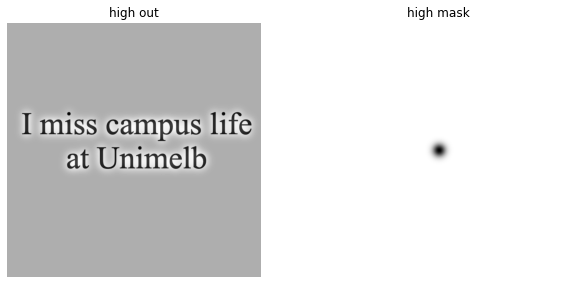

Threshold  25
MSE: 701.40, SSIM: 0.81


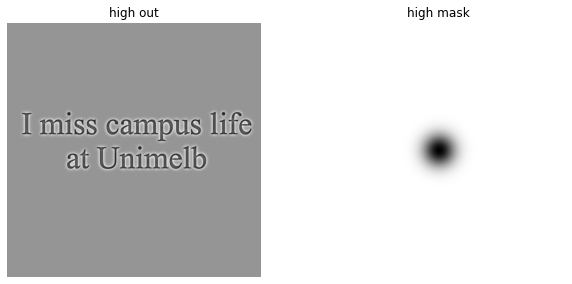

Threshold  50
MSE: 273.60, SSIM: 0.85


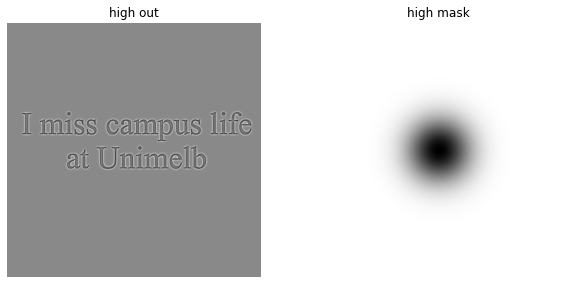

Threshold  100
MSE: 78.34, SSIM: 0.88


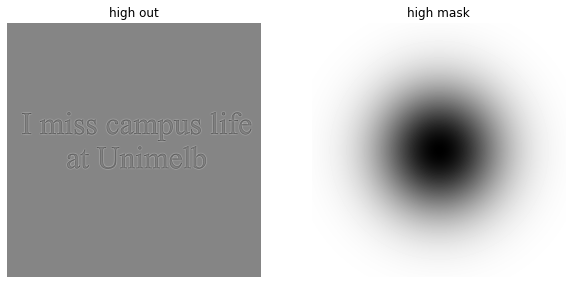

Threshold  150
MSE: 28.03, SSIM: 0.89


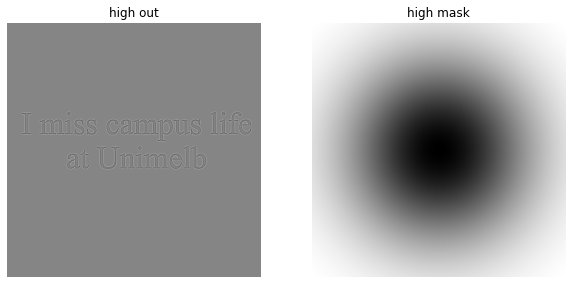

Threshold  200
MSE: 10.76, SSIM: 0.89


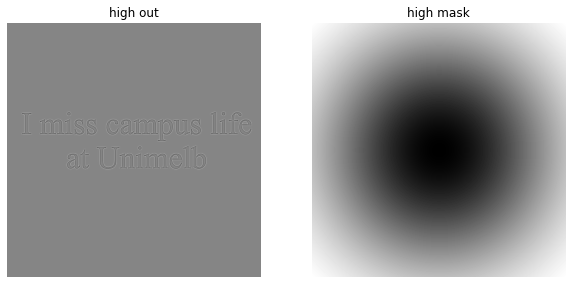

Threshold  500
MSE: 0.00, SSIM: 1.00


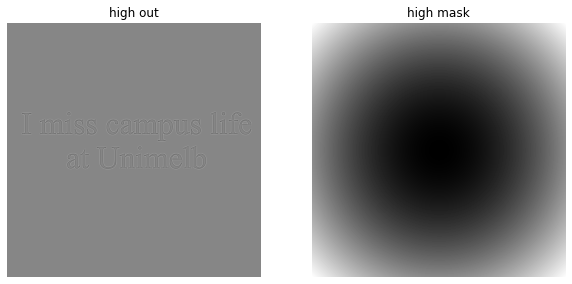

In [10]:
# visualise filtered image to select the best threshold
for t in thresholds_high:
    Images_HighPass(t)

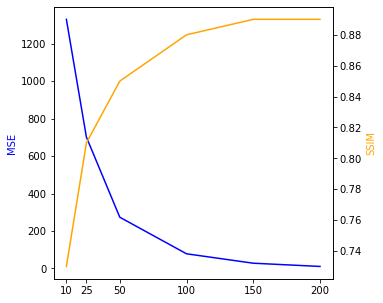

In [11]:
# results from the previous step
mse_high = [1330.43, 701.40, 273.60, 78.34, 28.03, 10.76]
ssim_high = [0.73, 0.81, 0.85, 0.88, 0.89, 0.89]

fig,ax = plt.subplots()
ax.plot(thresholds_high[:-1], mse_high, color='blue')
ax.set_ylabel('MSE', color = 'blue')
ax2 = ax.twinx()
ax2.plot(thresholds_high[:-1], ssim_high, color='orange')
ax2.set_ylabel('SSIM', color = 'orange')
ax2.set_xticks(thresholds_high[:-1])
fig.savefig('msg_plot.png',format='png', dpi=300, bbox_inches='tight')

#### Low Pass Filter 

In [12]:
# frequency thresholds 
thresholds_low = [10, 50, 100, 250, 500]

# Fourier transform 
f_l = np.fft.fft2(cover)
f_l = np.fft.fftshift(f_l)

In [13]:
def Images_LowPass(radius_low):
    f_low_filtered,mask_low = Gauss_LowPass(f_l,radius_low)

    # Invert Fourier transform to get the filtered image
    img_low = np.real(np.fft.ifft2(np.fft.fftshift(f_low_filtered)))
    
    # visualisation
    # visualisation setup
    fig,axs = plt.subplots(1,2)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    print("Threshold ", radius_low)
    compare_images(cover, img_low)
    plt.subplot(1,2,1)
    plt.imshow(img_low ,cmap='gray')  
    plt.title('low out')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask_low ,cmap='gray')  
    plt.title('low mask')
    plt.axis('off')
    plt.show()


Threshold  10
MSE: 1470.53, SSIM: 0.31


/Users/heekim/opt/anaconda3/envs/CV/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]


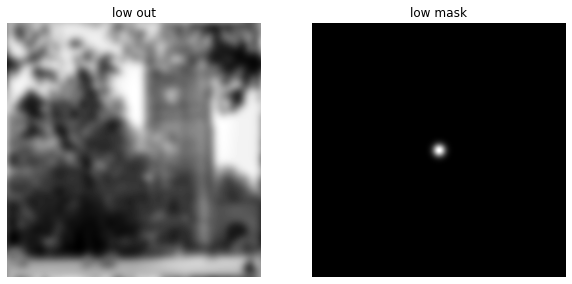

Threshold  50
MSE: 420.11, SSIM: 0.69


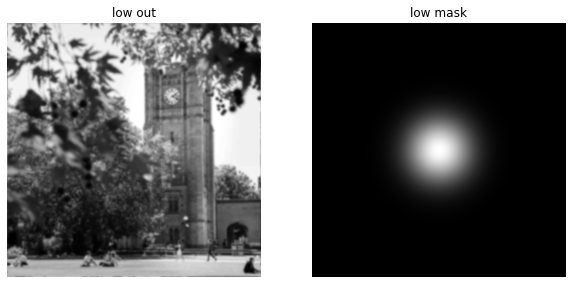

Threshold  100
MSE: 166.68, SSIM: 0.88


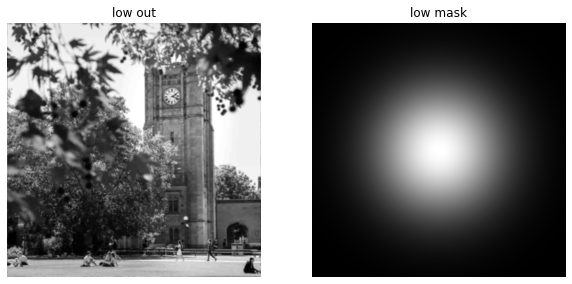

Threshold  250
MSE: 15.52, SSIM: 0.99


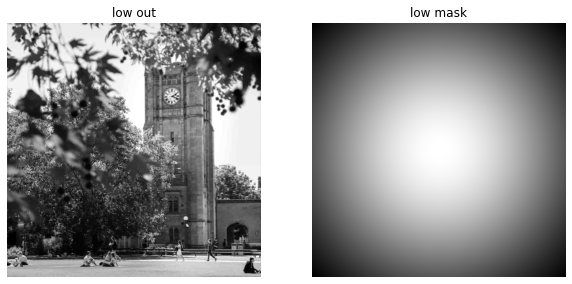

Threshold  500
MSE: 1.28, SSIM: 1.00


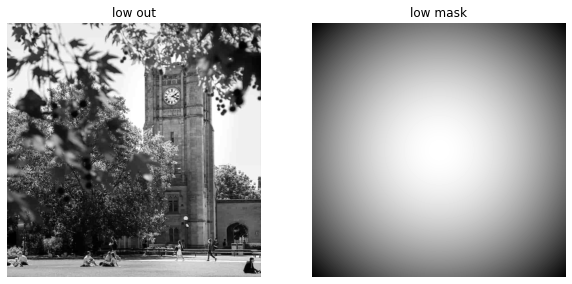

In [14]:
# visualise filtered image to select the best threshold
for t in thresholds_low:
    Images_LowPass(t)

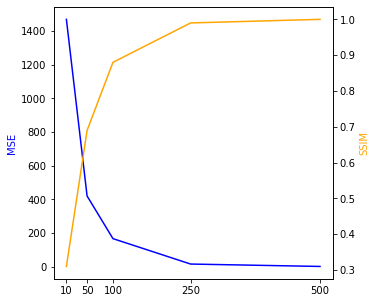

In [15]:
# results from the previous step
mse_low = [1470.53, 420.11, 166.68, 15.52, 1.28 ]
ssim_low = [0.31, 0.69, 0.88, 0.99, 1.00]

fig,ax = plt.subplots()
ax.plot(thresholds_low, mse_low, color='blue')
ax.set_ylabel('MSE', color = 'blue')
ax2 = ax.twinx()
ax2.plot(thresholds_low, ssim_low, color='orange')
ax2.set_ylabel('SSIM', color = 'orange')
ax2.set_xticks(thresholds_low)
fig.savefig('cover_plot.png',format='png', dpi=300, bbox_inches='tight')

In [16]:
# apply the best thresholds to the images

best_radius_high = 150
f_high_filtered, mask_high = Gauss_HighPass(f_h, best_radius_high)

best_radius_low = 250
f_low_filtered, mask_low = Gauss_LowPass(f_l,best_radius_low)

In [17]:
# add them in Fourier domain and convert to spatial domain
result_image = np.real(np.fft.ifft2(np.fft.fftshift(f_low_filtered + f_high_filtered)))

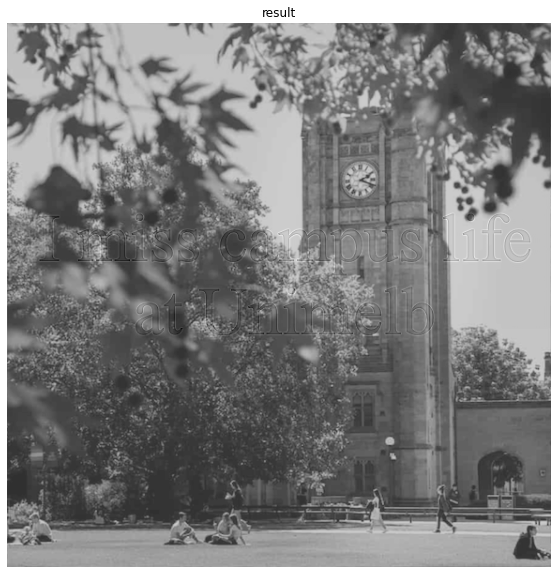

True

In [18]:
# visualise and save the final result image

plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(result_image ,cmap='gray')  
plt.title('result')
plt.axis('off')

plt.show()

cv2.imwrite("final_result.png", result_image) 
